In [1]:
# imports
import numpy as np
import pandas as pd
import json
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn2pmml import PMMLPipeline, sklearn2pmml
from nyoka import skl_to_pmml
from pypmml import Model
import base64
import matplotlib.pyplot as plt

# setting a random state to get consistent results
random_state = 7

In [2]:
##############################################################################################
################################### Helper Functions #########################################
##############################################################################################
# Save model to pmml file , convert model content to base64 encoded string

In [3]:
# path for saving & retrieving models
model_path = "models/"

# create a pmml pipeline with a model and save it to file
def save_to_pmml(model, algorithm, name, fit_pipeline=False, X=None, y=None, print_result=False):
    # build the PMML pipeline
    pmml_pipeline = PMMLPipeline([
        (algorithm, model)
    ])
    
    if (fit_pipeline):
        if (y is None):
            labels = pmml_pipeline.fit(X)
        else:
            labels = pmml_pipeline.fit(X, y)
        if (print_result):
            print(pmml_pipeline.predict(X))
    
    # convert into .pmml format and save
    sklearn2pmml(pmml_pipeline, model_path + name)
    
# path for model content saved in text
model_txt_path = "../test_files/models_txt/"
    
# convert simple model content into base64 encoded string so can be passed to ML plugin
def pmml_to_base64(model_file, txt_file):
    f = open(model_path + model_file)

    content = f.read() # string
    content_bytes = content.encode() # string of 8-bit bytes
    content_base64 = base64.b64encode(content_bytes) # base64 encoded string

    text_file = open(model_txt_path + txt_file, "w")
    text_file.write(str(content_base64))
    text_file.close()

    f.close()

In [ ]:
##############################################################################################
########################## AD Model for sample host health data ##############################
##############################################################################################
# For final demo

In [5]:
# pre-process training data to 10-min interval average values

avg_cpu = []
avg_memory = []
interval = 10
index = 0
count = 0
with open('hostHealth.json') as f:
    for doc in f:
        data = json.loads(doc)
        cpu = data["cpu_usage_percentage"]
        memory = data["memory_usage_percentage"]
        if index == 0 and count == 0:
            avg_cpu.append(cpu)
            avg_memory.append(memory)
            count += 1
        elif count == interval:
            avg_cpu.append(cpu)
            avg_memory.append(memory)
            index += 1
            count = 1
        else:
            avg_cpu[index] += cpu
            avg_memory[index] += memory
            count += 1
avg_cpu = [c / interval for c in avg_cpu]
avg_memory = [m / interval for m in avg_memory]

In [8]:
print(len(avg_cpu))
print(avg_cpu[:5])
print(len(avg_memory))
print(avg_memory[:5])

# 40320 raw points to 4032 10-min interval points
data_len = 4032

# training data
data = []
for i in range(data_len):
    data.append([avg_cpu[i], avg_memory[i]])

4032
[23.2, 29.9, 29.0, 26.2, 22.9]
4032
[42.0, 43.6, 41.7, 47.5, 51.3]


In [29]:
model = IsolationForest(
    n_estimators=30,
    max_samples=0.75,
    contamination=0.004,
    max_features=2,
    bootstrap=True,
    random_state=random_state
)

data = np.array(data)
model.fit(data)
results = model.predict(data)

In [30]:
print(data[results == -1])

[[32.9 74.5]
 [66.  52.6]
 [76.3 55.9]
 [67.4 47.8]
 [73.4 54. ]
 [56.5 42.9]
 [35.2 80.3]
 [35.7 74.7]
 [64.2 51.9]
 [49.5 41.7]
 [30.9 78.4]
 [52.8 55.3]
 [49.3 43.1]
 [72.  47.3]
 [66.8 50. ]
 [77.7 51.3]
 [29.8 73.9]]


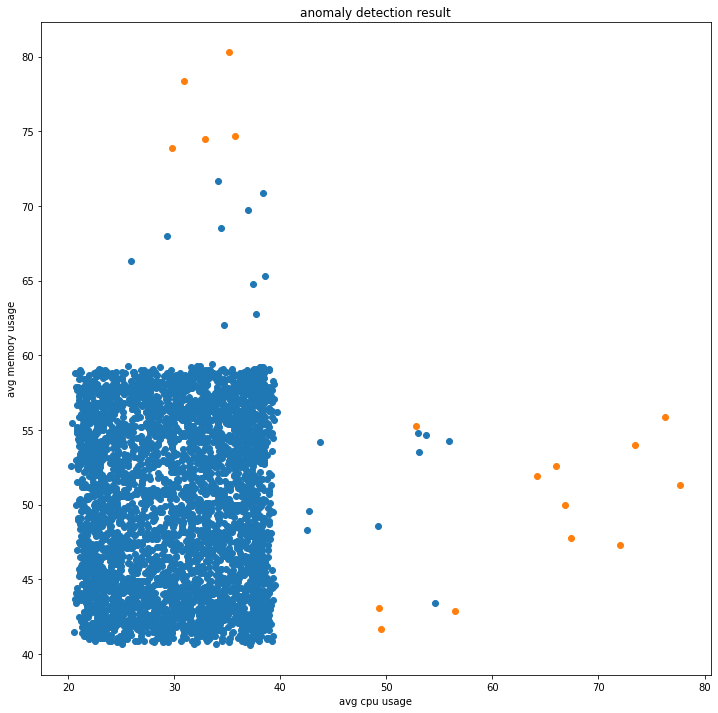

In [31]:
inliers = data[results == 1]
outliers = data[results == -1]

plt.figure(figsize=(12,12))
plt.scatter(*zip(*inliers))
plt.scatter(*zip(*outliers))
plt.title("anomaly detection result")
plt.xlabel("avg cpu usage")
plt.ylabel("avg memory usage")
plt.show()

In [32]:
save_to_pmml(model, "iforest", "if_hh.pmml")

pmml_to_base64("if_hh.pmml", "if_hh.txt")

model = Model.fromFile(model_path + "if_hh.pmml")
results = model.predict(data)
print(data[:5])
print(results[:5])

[[23.2 42. ]
 [29.9 43.6]
 [29.  41.7]
 [26.2 47.5]
 [22.9 51.3]]
[[0.19888064397537042, False], [0.2356930354567649, False], [0.20937303219833514, False], [0.2219987296415547, False], [0.2401945547446025, False]]


In [9]:
##############################################################################################
########################## AD Model for sample e-commerce data ###############################
##############################################################################################
# For final demo

In [33]:
# pre-process training data to 10-min interval average values

sum_failure = []
avg_revenue = []
interval = 10
index = 0
count = 0
with open('ecommerce.json') as f:
    for doc in f:
        data = json.loads(doc)
        failure = data["items_purchased_failure"]
        revenue = data["total_revenue_usd"]
        if index == 0 and count == 0:
            sum_failure.append(failure)
            avg_revenue.append(revenue)
            count += 1
        elif count == interval:
            sum_failure.append(failure)
            avg_revenue.append(revenue)
            index += 1
            count = 1
        else:
            sum_failure[index] += failure
            avg_revenue[index] += revenue
            count += 1
avg_revenue = [r / interval for r in avg_revenue]

In [34]:
print(len(sum_failure))
print(sum_failure[:5])
print(len(avg_revenue))
print(avg_revenue[:5])
data_len = 4032

# training data
data = []
for i in range(data_len):
    data.append([sum_failure[i], avg_revenue[i]])

4032
[0, 0, 0, 0, 0]
4032
[106.45, 136.47999999999996, 353.34600000000006, 196.29800000000003, 81.02400000000002]


In [38]:
model = IsolationForest(
    n_estimators=30,
    max_samples=0.75,
    contamination=0.004,
    max_features=2,
    bootstrap=True,
    random_state=random_state
)

data = np.array(data)
model.fit(data)
results = model.predict(data)

In [39]:
print(data[results == -1])

[[  14.      23.496]
 [   0.    1687.45 ]
 [   0.    1026.171]
 [  11.      53.574]
 [   9.      76.463]
 [  12.      43.979]
 [   7.      47.172]
 [   0.     456.964]
 [   5.      88.576]
 [  11.      39.157]
 [   0.     520.857]
 [   7.      24.278]
 [   5.      49.488]
 [   7.      37.328]
 [   7.      26.515]
 [   0.     540.212]
 [  11.      38.553]]


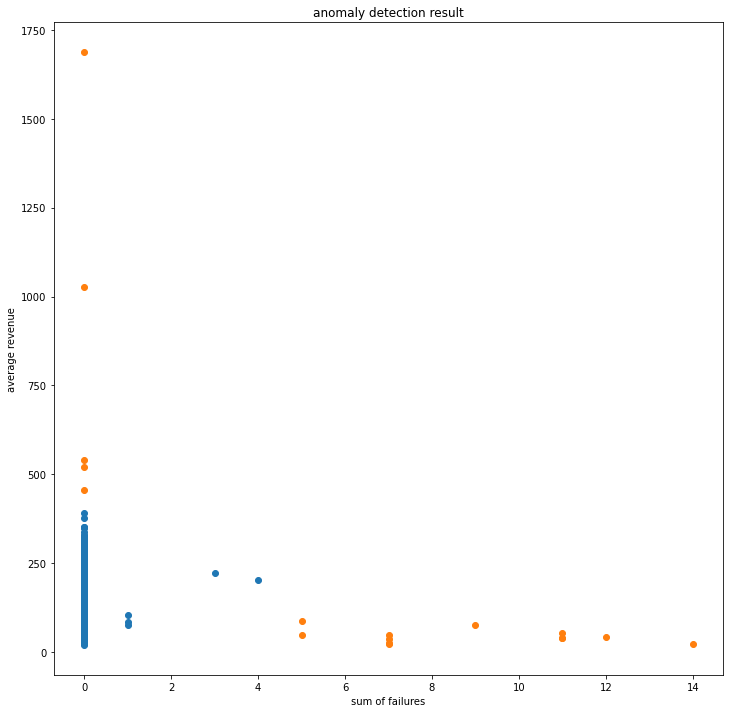

In [40]:
inliers = data[results == 1]
outliers = data[results == -1]

plt.figure(figsize=(12,12))
plt.scatter(*zip(*inliers))
plt.scatter(*zip(*outliers))
plt.title("anomaly detection result")
plt.xlabel("sum of failures")
plt.ylabel("average revenue")
plt.show()

In [41]:
save_to_pmml(model, "iforest", "if_ec.pmml")

pmml_to_base64("if_ec.pmml", "if_ec.txt")

model = Model.fromFile(model_path + "if_ec.pmml")
results = model.predict(data)
print(data[:5])
print(results[:5])

[[  0.    106.45 ]
 [  0.    136.48 ]
 [  0.    353.346]
 [  0.    196.298]
 [  0.     81.024]]
[[0.3624312592887491, False], [0.35395942894480475, False], [0.09442362750957889, False], [0.3256406833095509, False], [0.35424826757141675, False]]


In [11]:
##############################################################################################
################### AD Model for Randomly Generated Data with 2 Clusters######################
##############################################################################################
# For middle demo

In [36]:
# generate data

from sklearn.datasets import make_blobs

random_state = 7
n_samples = 500
outliers_fraction = 0.05
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

clustered_data = make_blobs(
    centers=[[2, 2], [-2, -2]], 
    cluster_std=[1.5, .3], 
    random_state=random_state,
    n_samples=n_inliers,
    n_features=2
)[0]

random_data = np.random.RandomState(random_state).uniform(
    low=-6, 
    high=6,
    size=(n_outliers, 2)
)

data = np.vstack((clustered_data, random_data))

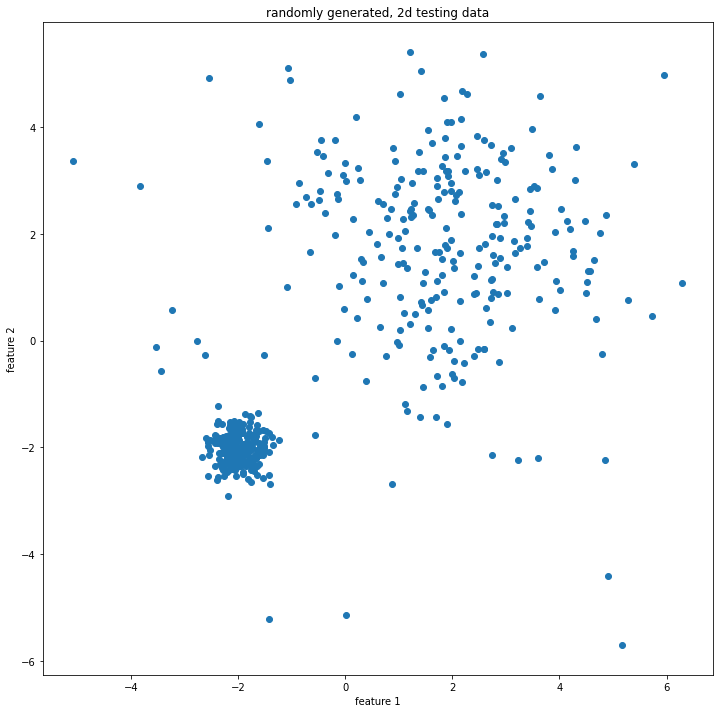

In [46]:
plt.figure(figsize=(12,12))
plt.scatter(*zip(*data))
plt.title("randomly generated, 2d testing data")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.show()

In [47]:
# model
model = IsolationForest(
    n_estimators=50,
    max_samples=0.5,
    contamination=outliers_fraction,
    max_features=2,
    bootstrap=True,
    random_state=random_state
)

data = np.concatenate([inliers, outliers], axis=0)

model.fit(data)

results = model.predict(data)

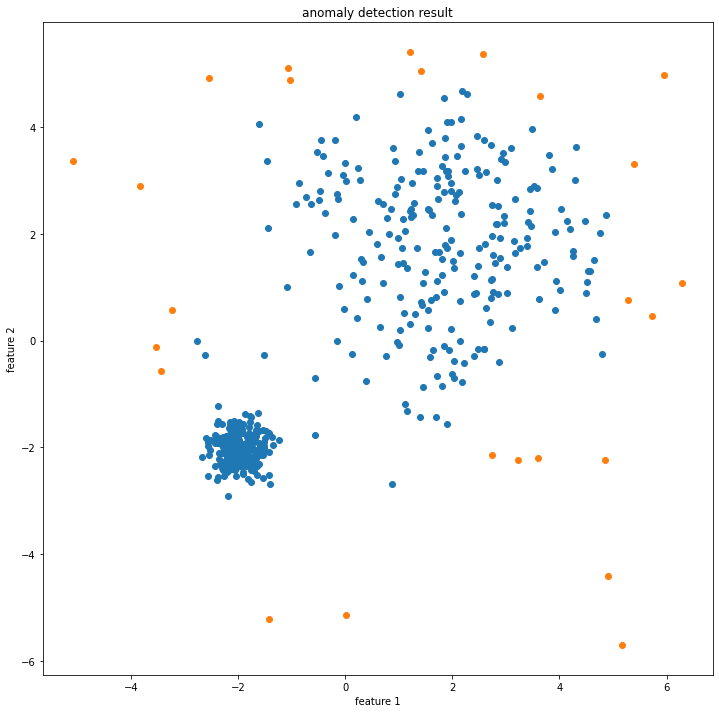

In [48]:
inliers = data[results == 1]
outliers = data[results == -1]

plt.figure(figsize=(12,12))
plt.scatter(*zip(*inliers))
plt.scatter(*zip(*outliers))
plt.title("anomaly detection result")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.show()

In [16]:
save_to_pmml(model, "iforest", "if_2d.pmml")

pmml_to_base64("if_2d.pmml", "if_2d.txt")

model = Model.fromFile(model_path + "if_2d.pmml")
results = model.predict(data)
# print(data[:10])
# print(results[:10])

In [145]:
##############################################################################################
########## AD model for Machine Temperature System Failure data in NAB datasets ##############
##############################################################################################
# Shingling experiment. End up NOT using this shingled model

In [152]:
# read data
MTSF = "./NAB-master/data/realKnownCause/machine_temperature_system_failure.csv"

# for training and testing
data = pd.read_csv(MTSF)

# for graphing
series = pd.read_csv(MTSF, header=0, index_col=0, parse_dates=True, squeeze=True)
train_size_graph = int(series.shape[0] * 0.75)
test_size_graph = series.shape[0] - train_size_graph

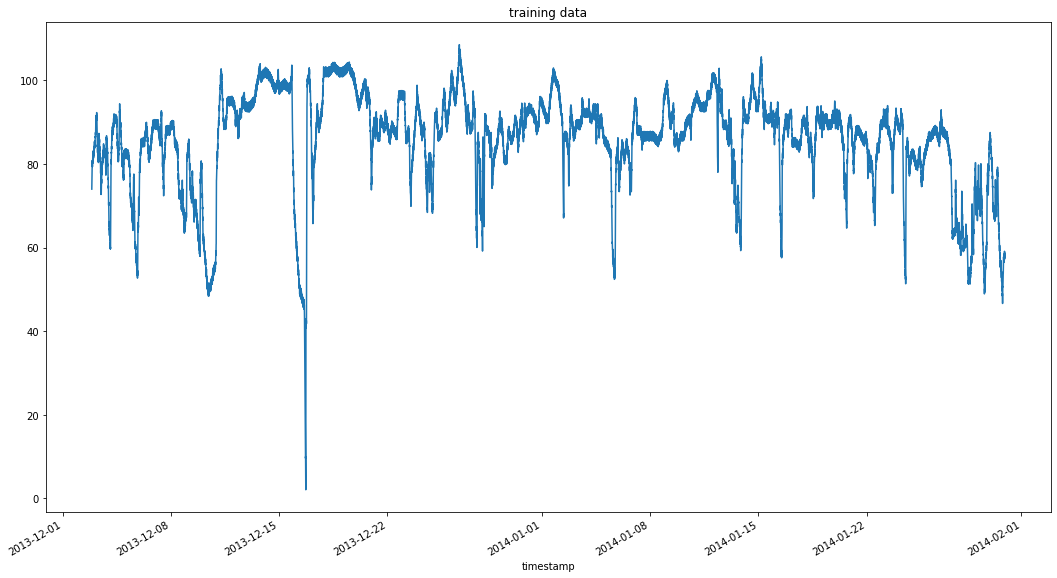

In [160]:
# graph of training data
train_graph = series[:train_size_graph]

plt.figure(figsize=(18,10))
train_graph.plot()
plt.title("training data")
plt.show()

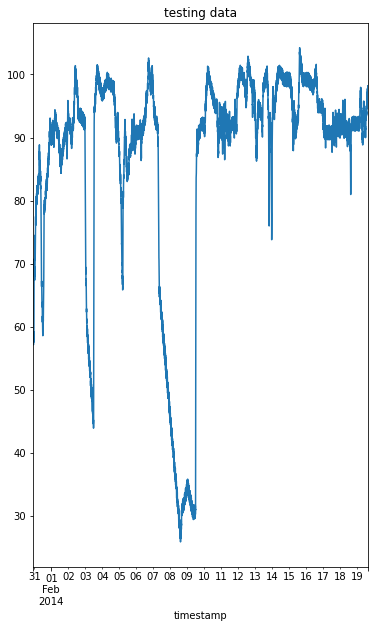

In [161]:
# graph of testing data
test_graph = series[train_size_graph:]

plt.figure(figsize=(6,10))
test_graph.plot()
plt.title("testing data")
plt.show()

In [177]:
# use the 'value' column
X = np.array(data['value'], ndmin=2)
dates = np.array(data['timestamp'], ndmin=2)
X = X.T
dates = dates.T

# we start on 2013-12-03 00:00:00, and end on 2014-2-18 23:55:00
X = X[33:22509]
dates = dates[33:22509]

# for later use, to find the anomaly dates
dates_shingled = []

# use shingling -> one data point for 1/3 hour. 1873 hours -> 5619 data points
shingle_size = 12
num_points = int(22476/shingle_size)
X_shingled = []

for i in range(num_points):
    cur = []
    for val in X[i*shingle_size:(i+1)*shingle_size]:
        cur.append(val[0])
    X_shingled.append(cur)
    dates_shingled.append(dates[i*shingle_size])
    
total_size = len(X_shingled)

In [180]:
# split training and testing data points
# 5619 * 0.75 ~= 4214 for training. 5619 - 4214 = 1405 for testing
train_size = int(total_size * 0.75)
test_size = total_size - train_size

# training
model = IsolationForest(
    n_estimators=20,
    max_samples=0.8,
    contamination=0.003,
    max_features=shingle_size,
    bootstrap=True,
    random_state=7
)
model.fit(X_shingled[:train_size])

# predict on training data
train_labels = model.predict(X_shingled[:train_size])

# predict on testing data
test_labels = model.predict(X_shingled[train_size:])

# check performance
anomalies_1 = np.where(train_labels == -1)[0]
print(anomalies_1)

anomalies_2 = np.where(test_labels == -1)[0]
print(anomalies_2)

# indices = [0, 1, 6, 7, 14, 16, 17, 27]
# for i in indices:
#     print()
#     print(X_shingled[anomalies[i]])
#     print(dates_shingled[anomalies[i]])

# for i in anomalies_1:
#     print(1)
#     print(X_shingled[i])
#     print(dates_shingled[i])
    
# for i in anomalies_2:
#     print(2)
#     print(X_shingled[train_size+i])
#     print(dates_shingled[train_size+i])

[327 328 329 330 568]
[ 96 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240]


In [181]:
##############################################################################################
########## AD model for Machine Temperature System Failure data in NAB datasets ##############
##############################################################################################
# For middle demo, without shingling

In [184]:
# use the 'value' column
X = np.array(data['value'], ndmin=2)
dates = np.array(data['timestamp'], ndmin=2)
X = X.T
dates = dates.T

total_size = len(X)

In [187]:
# split training and testing data points
train_size = int(total_size * 0.75)
test_size = total_size - train_size

# training
model = IsolationForest(
    n_estimators=20,
    max_samples=0.8,
    contamination=0.001,
    max_features=1,
    bootstrap=True,
    random_state=7
)
model.fit(X[:train_size])

# predict on training data
train_labels = model.predict(X[:train_size])

# predict on testing data
test_labels = model.predict(X[train_size:])

# check performance
anomalies_1 = np.where(train_labels == -1)[0]
print(anomalies_1)

anomalies_2 = np.where(test_labels == -1)[0]
print(anomalies_2)

# for i in anomalies_1:
#     print(1)
#     print(X[i])
#     print(dates[i])
    
# for i in anomalies_2:
#     print(2)
#     print(X[train_size+i])
#     print(dates[train_size+i])

[3971 3972 3973 3976 3977 3978 3979 3980 3981 3982 3983 3984 3985 3986
 3987 6845 6846 6848]
[2470 2473 2477 2479 2480 2481 2482 2483 2484 2485 2486 2487 2488 2489
 2490 2491 2492 2493 2494 2495 2496 2497 2498 2499 2500 2501 2502 2503
 2504 2505 2506 2508 2510]


In [188]:
save_to_pmml(model, "iforest", "if_mt.pmml")

pmml_to_base64("if_mt.pmml", "if_mt.txt")

In [6]:
##############################################################################################
######################################### Simple model #######################################
##############################################################################################
# For testing use

In [19]:
# generate dummy data
X = np.array([[1], [2], [3], [1], [2]])

# create, train the model
model = IsolationForest(
    n_estimators=5
)
model.fit(X)

# original output
og = model.predict(
    [[1], [2], [10], [100]]
)
print('prediction: ', og)

save_to_pmml(model, "iforest", "if_simple.pmml")

# pulling the saved model
model = Model.fromFile(model_path + model_name)

# predicting on non-anomalous datapoints & anomalous datapoints
result = model.predict(
    [[1], [2], [10], [100]]
)
print('prediction: ', result)

prediction:  [ 1  1 -1 -1]
prediction:  [[0.06570586922851246, False], [0.09082283791718504, False], [-0.19946269094999458, True], [-0.19946269094999458, True]]


In [9]:
pmml_to_base64("if_simple.pmml", "if_simple.txt")

In [131]:
##############################################################################################
######################################### AD model ###########################################
##############################################################################################
# For testing use

In [177]:
data = pd.read_csv("./NAB-master/data/realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv")

# grab the "value" column, and create the IF model
X = np.array(data['value'], ndmin=2)
X = X.T
model = IsolationForest(
    n_estimators=10,
    max_samples=0.5,
    contamination=0.1,
    max_features=1,
    bootstrap=True,
    random_state=7
)
features = ['value']
model.fit(X)
labels = model.predict(X)
print(X[:10])
print(labels[:10])

[[51.846]
 [44.508]
 [41.244]
 [48.568]
 [46.714]
 [44.986]
 [49.108]
 [40.47 ]
 [53.404]
 [45.4  ]]
[-1  1  1  1  1  1  1  1 -1  1]


In [157]:
save_to_pmml(model, "iforest", "if_model.pmml")

In [174]:
# pull the saved model, predict on the training data
model_fromFile = Model.fromFile(model_path + "if_model.pmml")
model = model_fromFile
labels = model.predict([[51], [44.5], ["47"]])
print(X[:10])
print(labels[:10])

[[51.846]
 [44.508]
 [41.244]
 [48.568]
 [46.714]
 [44.986]
 [49.108]
 [40.47 ]
 [53.404]
 [45.4  ]]
[[-0.007643447317459362, True], [0.0636098347759037, False], [0.021092430437043674, False]]


In [175]:
pmml_to_base64("if_model.pmml", "if_model.txt")

In [ ]:
##############################################################################################
################################# NYOKA package experiment ###################################
##############################################################################################
# For testing use

In [19]:
# grab the "value" column, and create the IF model
X = np.array(data['value'], ndmin=2)
X = X.T
model = IsolationForest(
    n_estimators=100,
    max_samples=0.5,
    contamination=0.1,
    max_features=1,
    bootstrap=True,
    random_state=7
)
features = ['value']
model.fit(X)
labels = model.predict(X)
print(X[:10])
print(labels[:10])

[[51.846]
 [44.508]
 [41.244]
 [48.568]
 [46.714]
 [44.986]
 [49.108]
 [40.47 ]
 [53.404]
 [45.4  ]]
[-1  1  1  1  1  1  1  1 -1  1]


In [20]:
# build the pipeline
skl_pipeline = Pipeline([
    ("iforest", model)
])

# convert into .pmml format and save
skl_to_pmml(pipeline=skl_pipeline, col_names=['x1'], pmml_f_name=model_path + "if_model_skl.pmml")

In [21]:
pmml_to_base64("if_model_skl.pmml", "if_model_skl.txt")

In [103]:
##############################################################################################
################################### Complex/large model ######################################
##############################################################################################
# For testing use

In [140]:
# read data, filter out the "value" column, and create the IF model
X = np.array(data['value'], ndmin=2)
X = X.T
model = IsolationForest(
    n_estimators=100,
    max_samples=0.5,
    contamination=0.1,
    max_features=1,
    bootstrap=True,
    random_state=7
)
features = ['value']
model.fit(X)
labels = model.predict(X)
print(labels[:10])

[-1  1  1  1  1  1  1  1 -1  1]


In [141]:
save_to_pmml(model, "iforest", "if_complex.pmml")

pmml_to_base64("if_complex.pmml", "if_complex.txt")

In [ ]:
##############################################################################################
######################################### OCS model ##########################################
##############################################################################################
# For testing use

In [54]:
# Another sample model of AD specific algorithm
from sklearn.svm import OneClassSVM

ocs = OneClassSVM(
    gamma='auto'
)

# generate dummy data
X = np.array([[1], [2], [2.5], [1], [2], [6], [7], [2], [1], [2.5]])

ocs.fit(X)
labels = ocs.predict(X)
print(labels[:10])

[ 1  1  1  1  1 -1 -1  1  1  1]


In [55]:
save_to_pmml(ocs, "oneClassSVM", "ocs.pmml")

In [56]:
ocs = Model.fromFile(model_path + "ocs.pmml")
labels = ocs.predict(X)
print(labels)

[[5.069983322059102e-09, False], [0.061918124421274756, False], [5.07019470852299e-09, False], [5.069983322059102e-09, False], [0.061918124421274756, False], [-0.29021460628540074, True], [-0.290221781561681, True], [0.061918124421274756, False], [5.069983322059102e-09, False], [5.07019470852299e-09, False]]


In [106]:
##############################################################################################
######################################### RFC model ##########################################
##############################################################################################
# For testing use

In [50]:
# Sample model for non-AD specific algorithm
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(
    n_estimators=10,
    max_samples=0.5,
    max_features=1,
    bootstrap=True,
    random_state=7
)

# generate dummy data
X = np.array([[1], [2], [3], [1], [2], [6], [7], [2], [1], [3]])
y = np.array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

rfc.fit(X, y)
labels = rfc.predict(X)
print(labels[:10])

[0 0 0 0 0 1 1 0 0 0]


In [36]:
save_to_pmml(rfc, "randomForestClassifier", "rfc.pmml")

# save_to_pmml(rfc, "randomForestClassifier", "rfc.pmml", True, X, y, True)

In [40]:
rfc = Model.fromFile(model_path + "rfc.pmml")
labels = rfc.predict(X)
print(labels)

[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.4, 0.6], [0.4, 0.6], [0.4, 0.6]]


In [ ]:
##############################################################################################
######################################### KMeans model #######################################
##############################################################################################
# For testing use

In [42]:
# Sample model for non-AD specific algorithm
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=2,
    random_state=7
)

# generate dummy data
X = np.array([[1,1], [1,2], [2,1], [10,6], [9,7], [10,8]])

kmeans.fit(X)
labels = kmeans.predict(X)
print(labels)

[1 1 1 0 0 0]


In [43]:
save_to_pmml(kmeans, "KMeans", "kmeans.pmml")

In [44]:
kmeans = Model.fromFile(model_path + "kmeans.pmml")
labels = kmeans.predict(X)
print(labels)

[['1', 111.1111111111111, 0.22222222222222301], ['1', 100.1111111111111, 0.5555555555555551], ['1', 94.77777777777777, 0.5555555555555551], ['0', 1.1111111111111116, 96.88888888888887], ['0', 0.44444444444444364, 90.88888888888889], ['0', 1.1111111111111116, 119.55555555555554]]


In [90]:
##############################################################################################
######################################### CSV to JSON ########################################
##############################################################################################
# For testing use: convert a dataset in csv to json

In [91]:
# convert csv files to json format
import csv, json

csv_path = "./NAB-master/data/realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv"
json_path = "../notes-test/test_data_NAB.json"

# read csv file and add to data
data = {}
with open(csv_path) as csv_file:
    reader = csv.DictReader(csv_file)
    for row in reader:
        timestamp = row['timestamp']
        data[timestamp] = row['value']

# create new json file and write to it
with open(json_path, 'w') as json_file:
    json_file.write(json.dumps(data, indent=4))